In [48]:
import imp
import os
import numpy as np
import torch.nn.functional as F

In [49]:
import os.path
from os import path

if path.exists('/content/MI') == False:
  os.mkdir('/content/MI')

if path.exists('/content/MI/images') == False:
  os.mkdir('/content/MI/images')

os.chdir('/content/MI')
!pwd
!ls

/content/MI
images


In [50]:
import os.path
from os import path

if path.exists('/content/MI1') == False:
  os.mkdir('/content/MI1')

if path.exists('/content/MI1/images') == False:
  os.mkdir('/content/MI1/images')

os.chdir('/content/MI1')
!pwd
!ls

/content/MI1
images


In [51]:
rmdir '/content/MI/.ipynb_checkpoints'

rmdir: failed to remove '/content/MI/.ipynb_checkpoints': No such file or directory


In [52]:
DATA_DIR = '/content/MI1'
print(os.listdir(DATA_DIR))

['.ipynb_checkpoints', 'images']


In [53]:
# import the modules
import os
from os import listdir
from PIL import Image
import cv2


# get the path/directory
folder_dir = "/content/MI/images"

i=0

for image in os.listdir(folder_dir):
 
    # check if the image ends with jpg
    if (image.endswith(".jpg")):
      img = cv2.imread("/content/MI/images/"+image)
      #img=np.uint8(img)
      dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
      status = cv2.imwrite('/content/MI1/images/grey%i.png' %i,dst)
      i+=1
      

In [54]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [55]:
image_size = 64
batch_size = 128
stats = (0.5),(0.5)  #mean and standard seviation of 0.5

In [56]:
rmdir '/content/MI1/.ipynb_checkpoints'

In [57]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.transforms.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [58]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [59]:
 
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
def denorm(img_tensors):
    return img_tensors*stats[1]+stats[0]

In [61]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

In [62]:
def show_batch(dl, nmax =64):
    for images,_ in dl:
        show_images(images,nmax)
        break

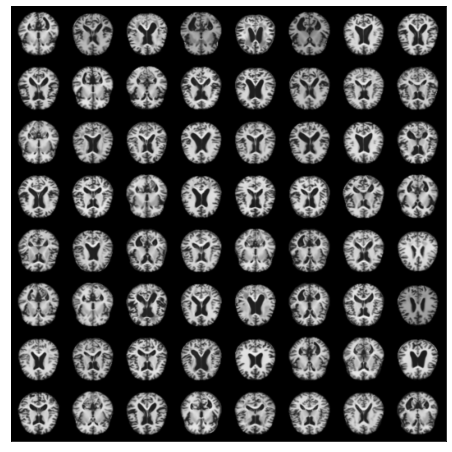

In [63]:
show_batch(train_dl)

In [64]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [65]:
device = get_default_device()
device

device(type='cuda')

In [66]:
train_dl = DeviceDataLoader(train_dl, device)

In [67]:
import torch.nn as nn

In [68]:

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [69]:
discriminator = to_device(discriminator, device)

In [70]:
latent_size = 128

In [71]:

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 1, 64, 64])


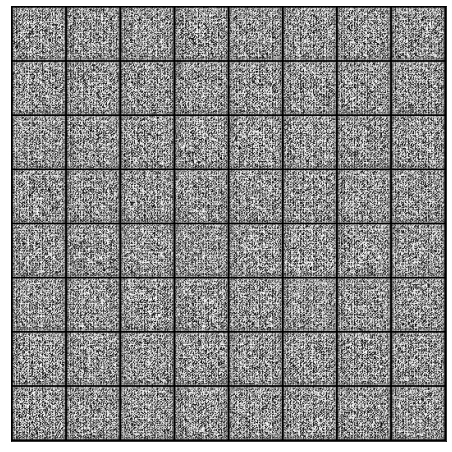

In [72]:
xb = torch.randn(batch_size,latent_size,1,1) #random instant tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [73]:
generator = to_device(generator, device)

In [74]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  
  real_preds = discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_preds).item()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

## Train Generator

In [75]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()


In [76]:
from torchvision.utils import save_image

In [77]:
sample_dir = '/content/generated'
os.makedirs(sample_dir, exist_ok=True)

In [78]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir,fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))
    

In [79]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


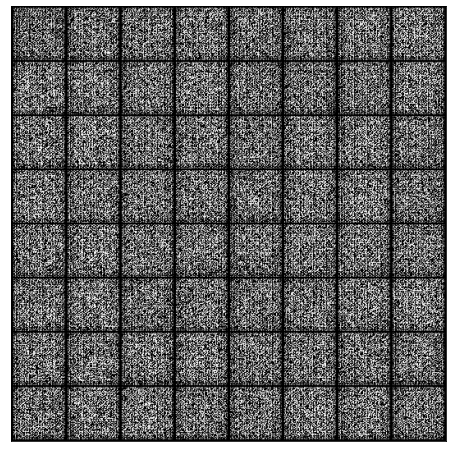

In [80]:
save_samples(0, fixed_latent)

In [81]:
from tqdm.notebook import tqdm
import torch.nn.functional as r

In [82]:
def fit(epochs, lr, start_idx):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr,  betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images,_ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
      

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}",epoch+1, epochs, loss_g, loss_d, real_score, fake_score)

    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores



In [83]:
#Training

In [84]:
lr = 0.0002
epochs = 50

In [85]:
history = fit(epochs, lr,1)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 1 50 4.764123439788818 0.15368646383285522 0.995608925819397 0.13731710612773895
Saving generated-images-0001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 2 50 5.4247026443481445 0.05007925257086754 0.9929078221321106 0.04181596636772156
Saving generated-images-0002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 3 50 5.842907905578613 0.028841812163591385 0.9951360821723938 0.023610658943653107
Saving generated-images-0003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 4 50 6.014434814453125 0.020086687058210373 0.9925036430358887 0.012417064979672432
Saving generated-images-0004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 5 50 6.443553447723389 0.01228383369743824 0.9969372749328613 0.009165027178823948
Saving generated-images-0005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 6 50 6.366312503814697 0.011802365072071552 0.9966068863868713 0.00835038349032402
Saving generated-images-0006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 7 50 6.653993606567383 0.014320721849799156 0.9956571459770203 0.009871368296444416
Saving generated-images-0007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 8 50 6.75709342956543 0.014524266123771667 0.9956510663032532 0.010083625093102455
Saving generated-images-0008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 9 50 7.002481460571289 0.013732247054576874 0.9963580369949341 0.009998813271522522
Saving generated-images-0009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 10 50 7.223362445831299 0.010508248582482338 0.9964527487754822 0.006914665922522545
Saving generated-images-0010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 11 50 7.198207378387451 0.010209847241640091 0.9969629049301147 0.007129681296646595
Saving generated-images-0011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 12 50 7.395027160644531 0.011225319467484951 0.9969059228897095 0.008082165382802486
Saving generated-images-0012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 13 50 4.643021106719971 0.023380402475595474 0.9836989045143127 0.006842262577265501
Saving generated-images-0013.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 14 50 7.767651081085205 6.948984146118164 0.9999361634254456 0.9985511898994446
Saving generated-images-0014.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 15 50 10.10245132446289 0.46957695484161377 0.9467889666557312 0.3285374045372009
Saving generated-images-0015.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 16 50 5.804827690124512 0.04516223445534706 0.9677545428276062 0.010562210343778133
Saving generated-images-0016.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 17 50 9.639098167419434 0.14253723621368408 0.9909194707870483 0.12247253209352493
Saving generated-images-0017.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 18 50 5.266336441040039 0.04154188185930252 0.975245475769043 0.0144390519708395
Saving generated-images-0018.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 19 50 13.725858688354492 0.12719868123531342 0.8941149711608887 1.0843114068848081e-05
Saving generated-images-0019.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 20 50 6.015255928039551 0.008494187146425247 0.9976577758789062 0.006114080548286438
Saving generated-images-0020.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 21 50 7.239528179168701 3.00360369682312 0.08210430294275284 1.3754628525930457e-05
Saving generated-images-0021.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 22 50 8.09827995300293 0.6155083179473877 0.980168879032135 0.4342048168182373
Saving generated-images-0022.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 23 50 5.214054107666016 0.44155654311180115 0.7002993822097778 0.0051859356462955475
Saving generated-images-0023.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 24 50 8.404949188232422 0.4239577651023865 0.9230138659477234 0.2763478457927704
Saving generated-images-0024.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 25 50 1.1605364084243774 0.7842662930488586 0.48969024419784546 0.03214458376169205
Saving generated-images-0025.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 26 50 5.073073387145996 0.494880348443985 0.9032859802246094 0.30399858951568604
Saving generated-images-0026.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 27 50 4.917474746704102 0.9646767377853394 0.9898121356964111 0.5862941741943359
Saving generated-images-0027.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 28 50 8.081086158752441 2.3350980281829834 0.9852917194366455 0.8675491213798523
Saving generated-images-0028.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 29 50 2.984867811203003 0.3845826983451843 0.8337271213531494 0.17197011411190033
Saving generated-images-0029.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 30 50 3.89163875579834 1.7763015031814575 0.9540634155273438 0.8086380958557129
Saving generated-images-0030.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 31 50 2.5477256774902344 0.5703509449958801 0.6156779527664185 0.05866106599569321
Saving generated-images-0031.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 32 50 2.7877073287963867 0.40780970454216003 0.6974334716796875 0.019709186628460884
Saving generated-images-0032.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 33 50 2.4102630615234375 0.6928032040596008 0.5697805285453796 0.09891669452190399
Saving generated-images-0033.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 34 50 4.511453151702881 0.8954982161521912 0.7520038485527039 0.43424034118652344
Saving generated-images-0034.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 35 50 1.464630365371704 0.7878925800323486 0.7453900575637817 0.37658166885375977
Saving generated-images-0035.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 36 50 2.238119602203369 0.8148385286331177 0.5730373859405518 0.17316162586212158
Saving generated-images-0036.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 37 50 1.9548211097717285 0.61527419090271 0.5922488570213318 0.04161369800567627
Saving generated-images-0037.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 38 50 4.562226295471191 1.603941798210144 0.9144768714904785 0.7700450420379639
Saving generated-images-0038.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 39 50 2.614990711212158 0.6399040222167969 0.6093328595161438 0.10317975282669067
Saving generated-images-0039.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 40 50 1.803611159324646 0.847835123538971 0.522875964641571 0.13425977528095245
Saving generated-images-0040.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 41 50 2.5344390869140625 0.7987745404243469 0.5174104571342468 0.03617078810930252
Saving generated-images-0041.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 42 50 2.1450181007385254 0.6622189879417419 0.5898404121398926 0.062067143619060516
Saving generated-images-0042.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 43 50 2.5617780685424805 0.7673648595809937 0.5439906120300293 0.030109170824289322
Saving generated-images-0043.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 44 50 3.041050434112549 1.8873214721679688 0.20820026099681854 0.003507481189444661
Saving generated-images-0044.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 45 50 3.315469980239868 0.459590882062912 0.86336350440979 0.2547159194946289
Saving generated-images-0045.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 46 50 5.367338180541992 0.6972534656524658 0.937614917755127 0.45514583587646484
Saving generated-images-0046.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 47 50 3.2763867378234863 0.17026695609092712 0.9503336548805237 0.10909059643745422
Saving generated-images-0047.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 48 50 4.082444190979004 1.456253170967102 0.9709147810935974 0.727735698223114
Saving generated-images-0048.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 49 50 1.1841046810150146 1.387397050857544 0.30291444063186646 0.10182175040245056
Saving generated-images-0049.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 50 50 2.3824543952941895 0.6287801265716553 0.6548161506652832 0.16922836005687714
Saving generated-images-0050.png


In [86]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [87]:
!zip -r /content/file.zip /content/generated

updating: content/generated/ (stored 0%)
updating: content/generated/generated-images-0017.png (deflated 5%)
updating: content/generated/generated-images-0026.png (deflated 5%)
updating: content/generated/generated-images-0016.png (deflated 5%)
updating: content/generated/generated-images-0027.png (deflated 6%)
updating: content/generated/generated-images-0022.png (deflated 6%)
updating: content/generated/generated-images-0015.png (deflated 5%)
updating: content/generated/generated-images-0014.png (deflated 5%)
updating: content/generated/generated-images-0035.png (deflated 3%)
updating: content/generated/generated-images-0008.png (deflated 7%)
updating: content/generated/generated-images-0001.png (deflated 9%)
updating: content/generated/generated-images-0043.png (deflated 3%)
updating: content/generated/generated-images-0048.png (deflated 3%)
updating: content/generated/generated-images-0050.png (deflated 3%)
updating: content/generated/generated-images-0024.png (deflated 6%)
updatin

In [88]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>